In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from abc import ABC, abstractmethod
from enum import Enum
from typing import List, Tuple
import cv2

In [88]:
MAPS = [
    ('canvas.png', [100, 100], 60),
    ('canvas2.png', [55, 100], 270),
    ('canvas3.png', [150, 150], 300),
]

In [87]:
UP_ANGLE = 270
MAX_DISTANCE = 50
OFF_ROAD = 0
ON_ROAD = 1
PIXEL_SPEED = 5
STEER_ANGLE = 12.5

In [3]:
class Action(Enum):
    LEFT= 1
    STRAIGHT = 2
    RIGHT = 3

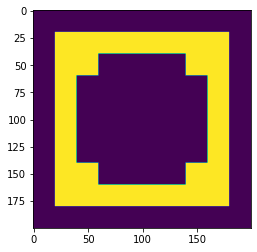

In [5]:
pixel_map = np.zeros((200, 200)) # OFF_ROAD

pixel_map[20:180, 20:40] = ON_ROAD
pixel_map[20:180, 160:180] = ON_ROAD
pixel_map[20:40, 20:180] = ON_ROAD
pixel_map[160:180, 20:180] = ON_ROAD

pixel_map[40:60, 140:160] = ON_ROAD
pixel_map[40:60, 40:60] = ON_ROAD
pixel_map[140:160, 140:160] = ON_ROAD
pixel_map[140:160, 40:60] = ON_ROAD


plt.imshow(pixel_map)
plt.show()

In [69]:
class Environment:
    def __init__(self, position: List[int], angle: float, pixel_map: np.ndarray):
        self.position = position
        self.angle = angle
        self.pixel_map = pixel_map
        
    def get_distance(self, angle: float = 0, draw_map: bool = False, draw_pixel_map: np.ndarray = None) -> int:
        y = self.position[0]
        x = self.position[1]
        
        if draw_map:
            draw_pixel_map[y, x] = 2
        
        x_inc = math.cos(math.radians(self.angle + UP_ANGLE + angle))
        y_inc = math.sin(math.radians(self.angle + UP_ANGLE + angle))
        
        for distance in range(1, MAX_DISTANCE):
            new_x = int(round(x + x_inc * distance))
            new_y = int(round(y + y_inc * distance))
            
            if (new_x < 0) or (new_x >= self.pixel_map.shape[1]) or (new_y < 0) or (new_y >= self.pixel_map.shape[0]):
                return distance - 1
            
            if self.pixel_map[new_y, new_x] == OFF_ROAD:
                return distance - 1
            
            if draw_map:
                draw_pixel_map[new_y, new_x] = 3
        
        return MAX_DISTANCE

    def get_distances(self, draw_map: bool = False, draw_pixel_map: np.ndarray = None) -> List[int]:
        distances = [ self.get_distance(-90, draw_map, draw_pixel_map), self.get_distance(-45, draw_map, draw_pixel_map), self.get_distance(0, draw_map, draw_pixel_map), self.get_distance(45, draw_map, draw_pixel_map), self.get_distance(90, draw_map, draw_pixel_map) ]
        
        return distances
    
    def move(self, pixel_speed: float = PIXEL_SPEED) -> None:
        y = self.position[0]
        x = self.position[1]
        
        x_inc = math.cos(math.radians(self.angle + UP_ANGLE)) * pixel_speed
        y_inc = math.sin(math.radians(self.angle + UP_ANGLE)) * pixel_speed
        
        self.position[1] += int(round(x_inc))
        self.position[0] += int(round(y_inc))
        
    def is_on_road(self) -> bool:
        y = self.position[0]
        x = self.position[1]
        
        if (x < 0) or (x >= self.pixel_map.shape[1]) or (y < 0) or (y >= self.pixel_map.shape[0]):
                return False
        
        return self.pixel_map[y, x] != OFF_ROAD
    
    def steer_left(self, angle: float = STEER_ANGLE) -> None:
        self.angle -= angle
        
    def steer_right(self, angle: float = STEER_ANGLE) -> None:
        self.angle += angle
        
    def act(self, action: Action) -> None:
        if action == Action.LEFT:
            print('Left')
            self.steer_left()
        elif action == Action.RIGHT:
            print('Right')
            self.steer_right()
        else:
            print('Straight')
            
    def get_status(self, draw_map: bool = False, draw_pixel_map: np.ndarray = None) -> Tuple[bool, List[int]]:
        return ( not self.is_on_road(), self.get_distances(draw_map, draw_pixel_map))
    
    def next(self, action: Action, draw_map: bool = False, draw_pixel_map: np.ndarray = None) -> Tuple[bool, List[int]]:
        self.act(action)
        self.move()
        return self.get_status(draw_map, draw_pixel_map)

In [57]:
class Driver(ABC):
    @abstractmethod
    def steer(self, distances: List[int]) -> Action:
        pass

class BaselineDriver(Driver):
    def steer(self, distances: List[int]) -> Action:
        sensor_id = np.argmax(distances)
        if sensor_id == 2: # straight takes precedence
            return Action.STRAIGHT
        elif sensor_id <= 1:
            return Action.LEFT
        elif sensor_id >= 3:
            return Action.RIGHT
        
class Baseline2Driver(Driver):
    def steer(self, distances: List[int]) -> Action:
        left_sum = np.sum(np.array(distances)[:3])
        right_sum = np.sum(np.array(distances)[2:])
        
        if left_sum > right_sum:
            return Action.LEFT
        elif left_sum < right_sum:
            return Action.RIGHT
        else:
            return Action.STRAIGHT

[150, 150] False [13, 28, 29, 11, 10]
Step: 1
Left
[148, 145] False [14, 22, 50, 11, 10] Action.LEFT
Step: 2
Left
[147, 140] False [13, 18, 50, 12, 9] Action.LEFT
Step: 3
Left
[147, 135] False [13, 14, 50, 16, 10] Action.LEFT
Step: 4
Left
[148, 130] False [11, 11, 36, 50, 12] Action.LEFT
Step: 5
Right
[148, 125] False [9, 12, 40, 20, 12] Action.RIGHT
Step: 6
Right
[147, 120] False [9, 14, 39, 16, 11] Action.RIGHT
Step: 7
Right
[145, 115] False [11, 22, 38, 12, 11] Action.RIGHT
Step: 8
Left
[144, 110] False [11, 18, 28, 50, 10] Action.LEFT
Step: 9
Right
[142, 105] False [13, 20, 28, 50, 10] Action.RIGHT
Step: 10
Right
[140, 101] False [15, 19, 25, 50, 10] Action.RIGHT
Step: 11
Right
[137, 97] False [16, 17, 24, 50, 11] Action.RIGHT
Step: 12
Right
[133, 94] False [15, 15, 24, 50, 11] Action.RIGHT
Step: 13
Right
[129, 92] False [14, 13, 25, 50, 11] Action.RIGHT
Step: 14
Right
[124, 90] False [12, 12, 24, 50, 12] Action.RIGHT
Step: 15
Right
[119, 89] False [10, 12, 23, 48, 15] Action.RIGHT

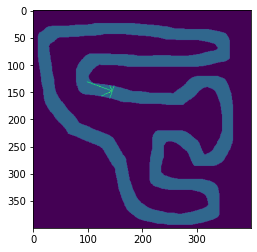

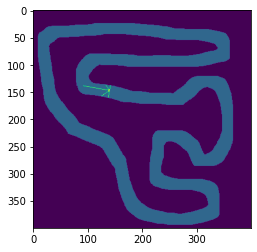

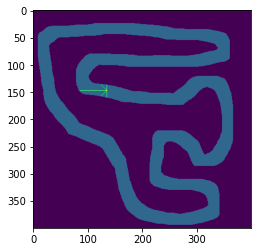

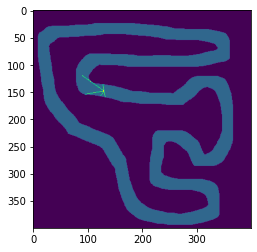

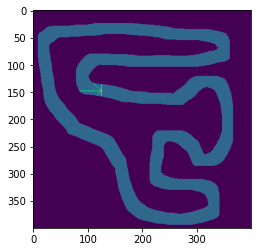

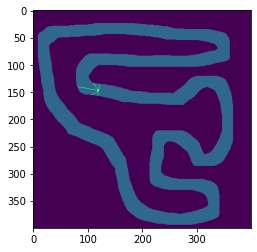

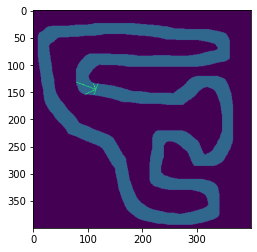

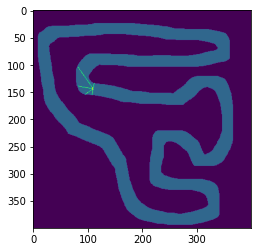

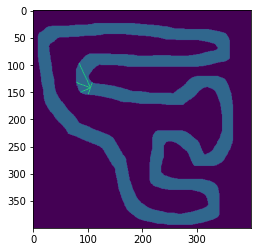

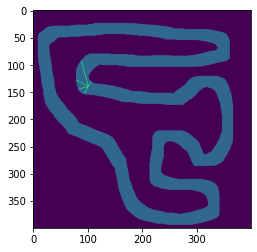

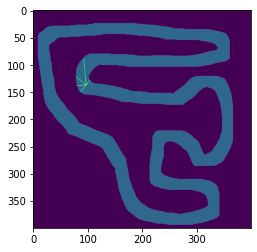

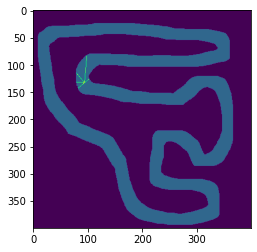

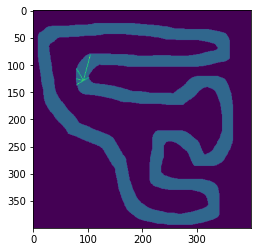

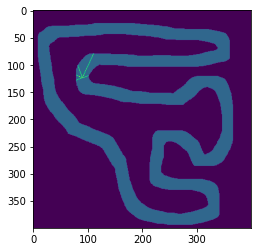

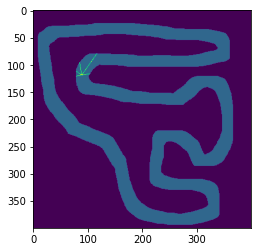

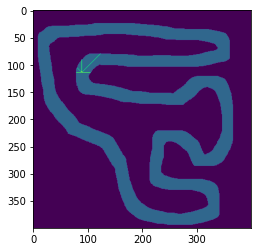

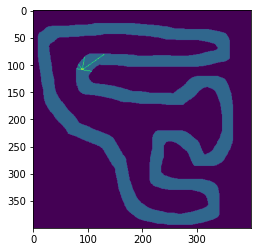

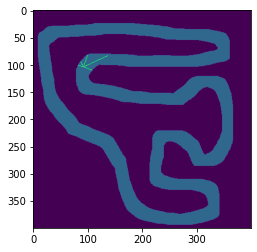

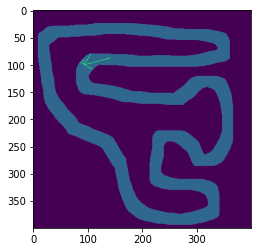

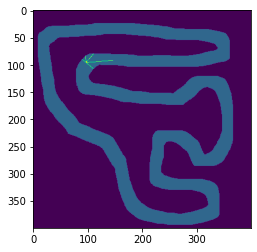

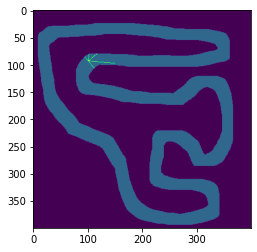

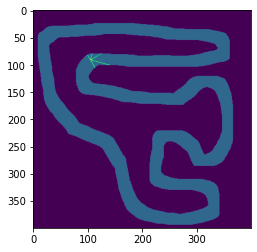

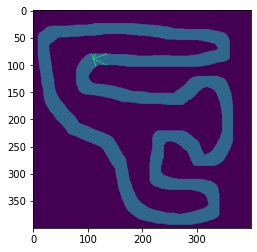

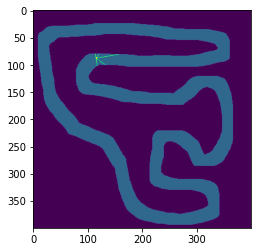

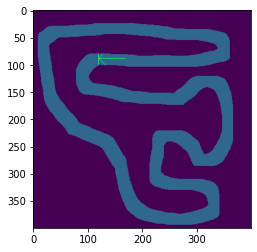

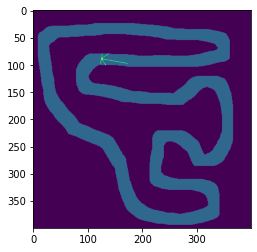

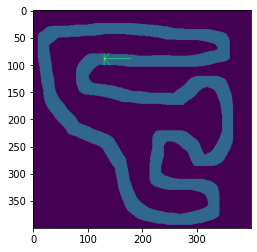

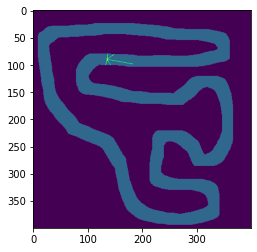

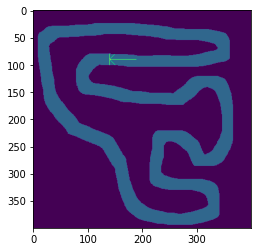

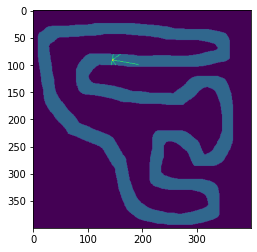

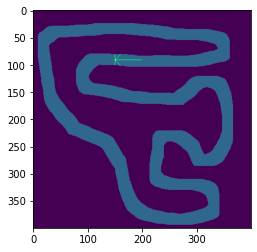

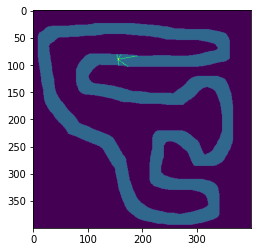

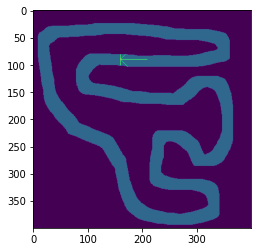

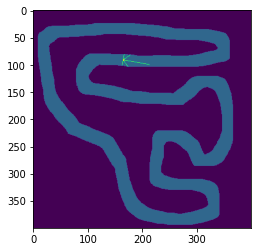

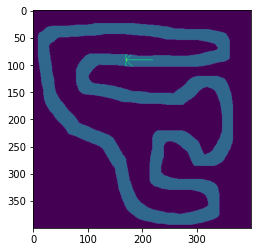

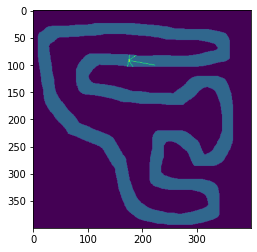

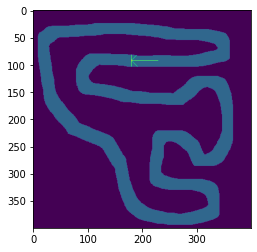

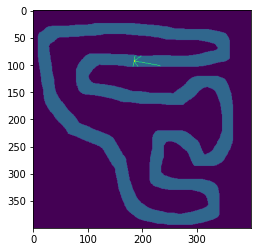

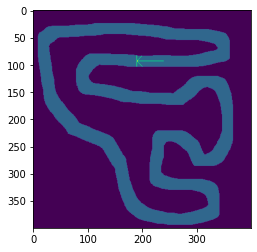

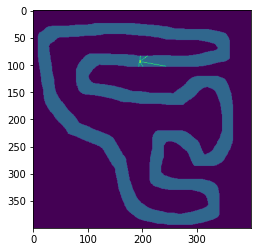

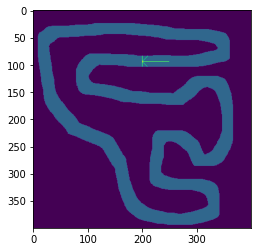

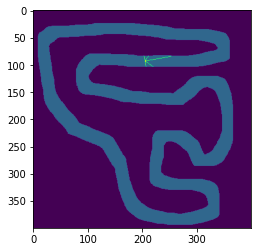

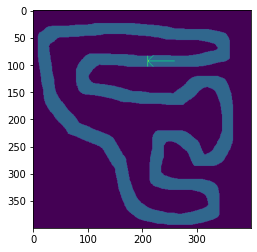

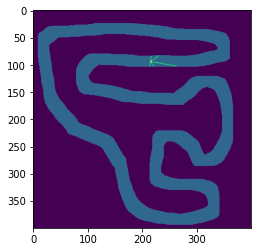

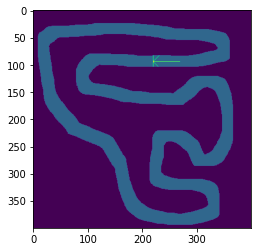

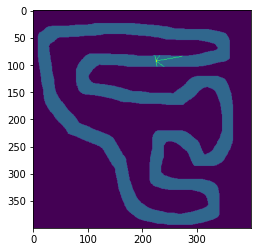

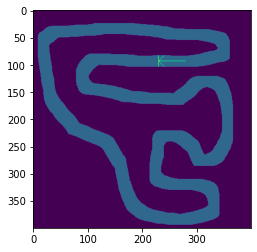

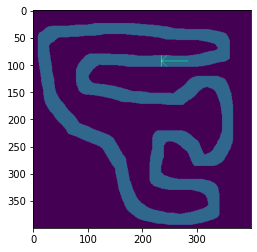

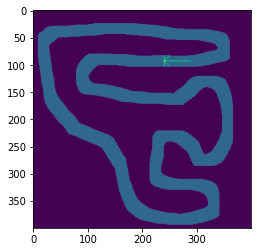

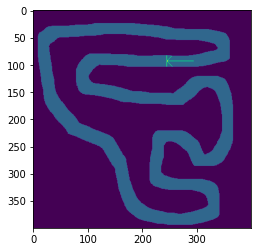

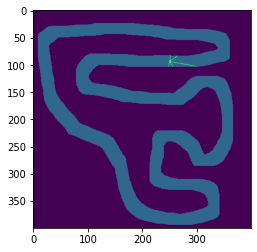

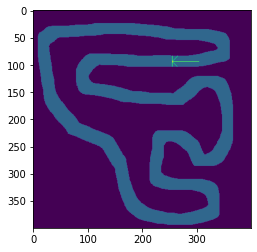

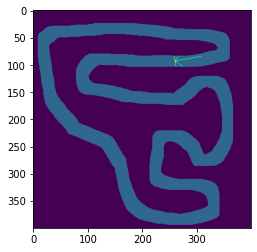

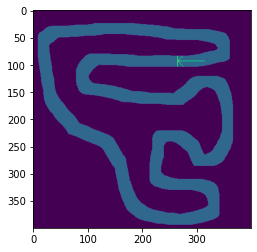

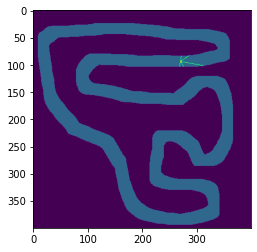

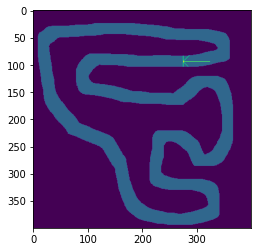

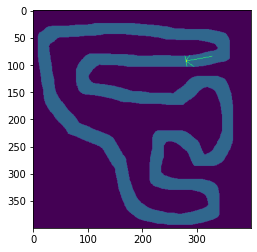

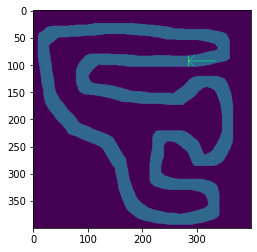

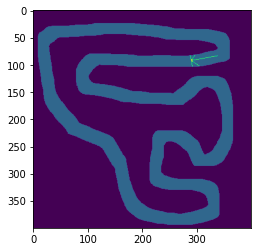

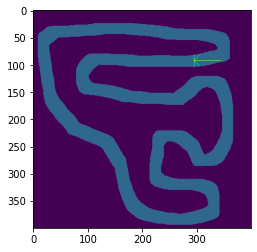

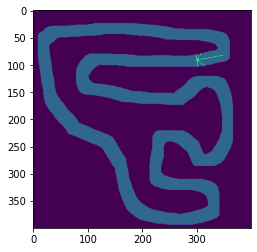

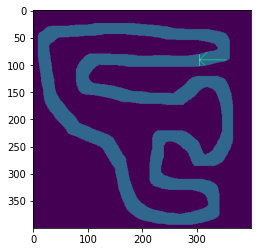

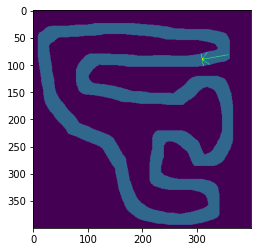

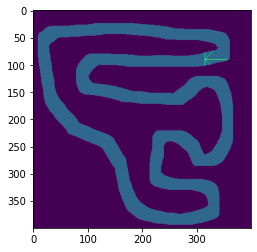

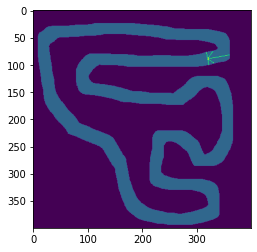

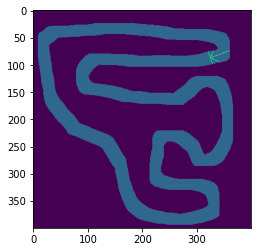

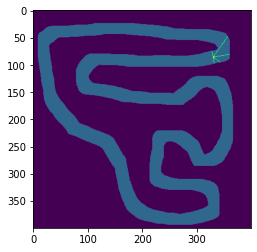

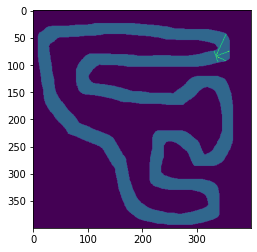

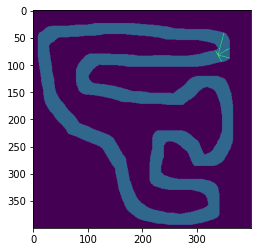

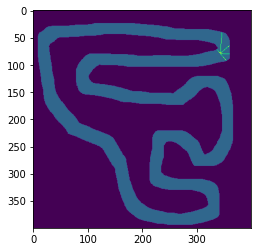

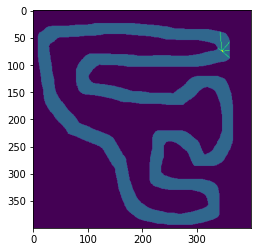

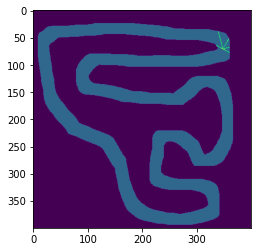

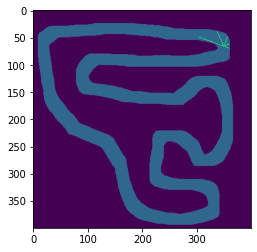

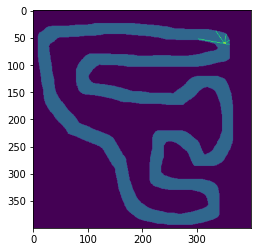

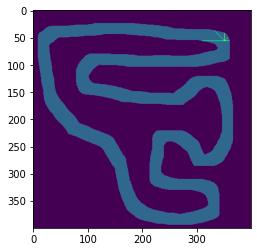

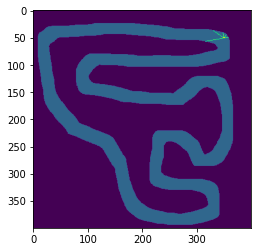

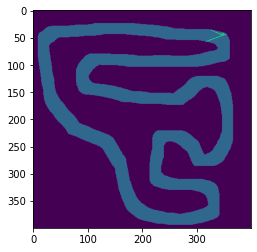

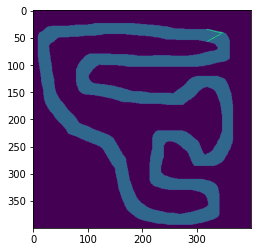

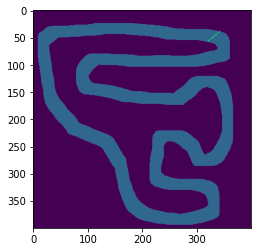

In [90]:
#env = Environment([100, 100], 60, pixel_map)
#env = Environment([55, 100], 270, pixel_map)
env = Environment([150, 150], 300, pixel_map)
driver = Baseline2Driver()

maps = []
done = False
reward_sum = 0

map = pixel_map.copy()
_, distances = env.get_status(True, map)
print(env.position, done, distances)

for s in range(200):
    print('Step:', s+1)
    
    map = pixel_map.copy()
    decision = driver.steer(distances)
    done, distances = env.next(decision, True, map)
    print(env.position, done, distances, decision)
    reward_sum += 1 if not done else 0
    maps.append(map)
    
    if done:
        print('Rewards:', reward_sum)
        break
    
total_maps = len(maps)

for i, map in enumerate(maps):
    plt.imshow(map)
    #plt.savefig(f'./driver/{i:02d}.png')
    plt.show()

In [ ]:
import imageio
with imageio.get_writer('./driver/movie.gif', mode='I') as writer:
    for filename in [ f'./driver/{i:02d}.png' for i in range(100) ]:
        image = imageio.imread(filename)
        writer.append_data(image)

In [81]:
def load_pixel_map(image_name):
    image = cv2.imread(image_name, cv2.IMREAD_UNCHANGED)
    image = image[:,:,3] // 255
    
    return image

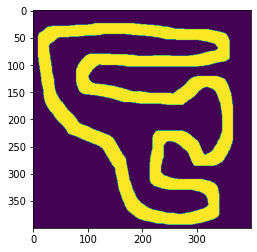

In [85]:
pixel_map = load_pixel_map('canvas3.png')

plt.imshow(pixel_map)
plt.show()